# RAG のための前処理

指定ディレクトリ内のすべての .txt ファイルを読み込み、NLTK を使ってテキストを文ごとに分割し、指定した文数ごとにチャンク化した上で、各チャンクの埋め込みを生成して出力します。

split_text_into_chunks 関数
NLTK の sent_tokenize を使用してテキストを文単位に分割し、max_sentences 毎に結合してチャンク化しています。

get_embedding 関数
最新の OpenAI API では、input パラメータにテキストのリストを渡す必要があるため、input=[text] としています。
生成された応答から、最初のチャンクの埋め込みを取り出して返します。

main 関数
指定ディレクトリ内の全 .txt ファイルを読み込み、各ファイルのテキストをチャンクに分割し、各チャンクに対して埋め込みを生成、最初の5次元だけを出力しています。

このコードを実行すれば、まずは小さなサンプルテキストを使った前処理と埋め込み生成の流れを体験できます。
その後、生成した埋め込みを Pinecone や Weaviate などのベクトルデータベースに保存するなど、RAG システムの次のステップに進むことができます。

### テキストの分割・前処理
- 長い文章は、意味のまとまりごとに分割する必要があります。

- たとえば、「文章を文単位に分割し、さらにいくつかの文ごとにまとめてチャンクを作る」方法が考えられます。

### vectorsをアップロードする際の注意点
- 一括でアップロードできる合計データ量は4MB
    - チャンク本文（text）のサイズ × 件数 + 埋め込みベクトル（1536次元, float32） × 件数 < 数MB
    - 私のアップロードコードは627件以上もあるので、100件ずつ小分けでアップロードする必要がある。（バッチ処理）
- アップロード時と検索時で同じembeddingモデルを使うこと
    - 本.ipynbで作成するembeddingモデルは、/Users/gota/docker/hamster_rag_server/app/rag_logic.pyで呼び出して活用する際のモデルと同じものを使う必要がある。
    > Pineconeは「同じ次元・同じembedding空間」のベクトルしか比較できない。
    > 違うモデル＝全く異なる空間＝スコアも0付近しか出ない＝マッチしない。

### 私のYouTubeシナリオをチャンクする際の注意点
- 私のYouTubeシナリオは基本的には句読点を用いておらず、その代わりに文章を改行して書いている。
    - <span style="color:red;">これがチャンクとして認識できない主因になりうる。(RAG精度が下がる)
    - <span style="color:red;">embeddingやAPI側のtop_k設定・前処理の影響も大きい。

    **一般的な文章構成の例：**
    > 皆さんこんにちは、Goです。今回は、脱走したハムを捕まえる方法、を紹介します。

    **チャンク元の.txtファイルに記述されている文章構成の例：**
    > 皆さんこんにちは  
    > Goです  
    > 今回は  
    > 脱走したハムを捕まえる方法  
    > を紹介します

# 🔧 これまでのステップ：RAG構築の準備プロセス
### 1. Pineconeのセットアップ
- PineconeのWebコンソールにログインし、新しいプロジェクト・インデックス（hamster-embeddings）を作成。

- 設定内容：
    - Dimension: 1536（OpenAIのtext-embedding-3-smallに対応）
    - Metric: cosine
    - Type: Dense
    - Capacity Mode: Serverless
    - Cloud: AWS、Region: us-east-1

### 2. Docker環境の構築
- Jupyter環境でNotebookを使ってRAG処理を行うため、DockerでPython+Jupyterの環境を構築。

- requirements.txtに以下の主要ライブラリを指定：
    - openai>=1.0.0
    - pinecone-client==2.2.4
    - httpx
    - nltk
    - jupyter

- Dockerfileでは追加で build-essential, ca-certificates, curl などもインストールし、通信や証明書の問題を回避。

### 3. テキストデータの分割とベクトル化
- senarios/ ディレクトリ内の .txt ファイルを読み込み、NLTKの sent_tokenize を使って文単位でチャンクに分割。

- OpenAIの text-embedding-3-small モデルを使って、各チャンクの文章を1536次元の埋め込みベクトルに変換。

### 4. Pineconeへのアップロード（Upsert）
- pinecone.Index.upsert() により、ベクトルとメタデータ（元のテキスト）をPineconeに保存。

- 実行成功後、Pineconeのダッシュボードで Record Count: 11 を確認（→成功！🎉）

### Dockerコンテナ起動方法
- Docker Image を構築する。
    - ❯ docker build -t hamster-chunk-text .
- Docker Container を使う
    - ❯ docker run -it -p 8888:8888 --name hamster-chunk-text \
  --env-file .env \
  -v $(pwd)/senarios:/app/senarios \
  hamster-chunk-text

### VSCodeの中で、コンテナを実行する（カーネルに指定する）方法
- ターミナル上でDocker Container をrunしたあとに出てくる以下のログをコピーしておく。
    - [I 2025-05-02 08:59:45.108 ServerApp] http://127.0.0.1:8888/tree
- VSCode で、この .ipynb を開き、

    Notebook 上部に表示される カーネル選択バーで「既存のJupyterサーバーに接続」を選択し、

    先ほどコピーした http://127.0.0.1:8888/... を貼り付ける。

In [1]:
import socket

try:
    print("🔍 解決結果:", socket.gethostbyname("hamster-embeddings-4ak3maz.svc.us-east-1-aws.pinecone.io"))
except Exception as e:
    print("❌ 名前解決できませんでした:", e)


🔍 解決結果: 34.230.203.60


In [2]:
print('hello, http://127.0.0.1:8888/tree')

hello, http://127.0.0.1:8888/tree


In [4]:
%pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1
    Uninstalling pip-25.1:
      Successfully uninstalled pip-25.1
Note: you may need to restart the kernel to use updated packages.


In [12]:
from openai import OpenAI
from pinecone import Pinecone
from nltk.tokenize import sent_tokenize

%pip install matplotlib
import matplotlib.pyplot as plt

%pip install pandas
import pandas as pd

import nltk
import os
import re

nltk.download('punkt')
nltk.download('punkt_tab')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
# OpenAI クライアントの初期化
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Pinecone クライアントの初期化
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

# インデックスに接続
index = pc.Index("hamster-embeddings")

# コンテナのディレクトリ
directory = "./senarios"

### ✅️粒度変更の効果
- MAX_SENTENCES_PER_CHUNK = 1
    - １文ずつに細かくチャンク化。検索ヒットはピンポイントになりやすいが、文脈が薄くなる。
- MAX_SENTENCES_PER_CHUNK = 3 以上
    - → ３文まとめて１チャンク。文脈は豊かになるが、不要な情報も含みやすく、トークン数超過リスクも増す。

- まずは MAX_SENTENCES_PER_CHUNK = 1 や 3 を試してみて、FastAPI／Flutter 側で結果の挙動を見ながら最適値を探してみてください。

In [ ]:
# 1チャンクあたりの文数をここで調整
MAX_SENTENCES_PER_CHUNK = 4

def split_text_into_chunks(text: str, max_sentences: int = MAX_SENTENCES_PER_CHUNK) -> list:
    """テキストを文単位に分割し、max_sentences 毎にまとめたチャンクのリストを返す"""
    sentences = sent_tokenize(text)
    chunks = []
    for i in range(0, len(sentences), max_sentences):
        chunk = " ".join(sentences[i:i+max_sentences])
        chunks.append(chunk)
    return chunks

def get_embedding(text):
    res = client.embeddings.create(input=[text], model="text-embedding-3-small")
    return res.data[0].embedding

# これは一般的な文章構成の場合
# def split_to_sentence_chunks(text, max_sentences=5, max_chars=2000):
#     sentences = re.split(r'(?<=[。！？])', text)
#     chunks = []
#     chunk = ''
#     count = 0
#     for sentence in sentences:
#         if sentence.strip() == '':
#             continue
#         # 追加：チャンクのサイズがmax_charsを超えるなら分割
#         if len(chunk.encode('utf-8')) + len(sentence.encode('utf-8')) > max_chars:
#             if chunk:
#                 chunks.append(chunk.strip())
#             chunk = ''
#             count = 0
#         chunk += sentence
#         count += 1
#         if count >= max_sentences:
#             chunks.append(chunk.strip())
#             chunk = ''
#             count = 0
#     if chunk:
#         chunks.append(chunk.strip())
#     return chunks

# 私のYouTubeシナリオの場合
def split_to_line_chunks(text, max_lines=5, max_chars=2000):
    # 1行を1文とみなす
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    chunks = []
    chunk = ""
    count = 0
    for line in lines:
        # バイト数制限
        if len(chunk.encode("utf-8")) + len(line.encode("utf-8")) > max_chars:
            if chunk:
                chunks.append(chunk.strip())
            chunk = ""
            count = 0
        chunk += line + "\n"
        count += 1
        if count >= max_lines:
            chunks.append(chunk.strip())
            chunk = ""
            count = 0
    if chunk:
        chunks.append(chunk.strip())
    return chunks

In [ ]:
# 1チャンクあたりの文数をここで調整
MAX_SENTENCES_PER_CHUNK = 5  # 3~10くらいで試せます

# チャンクと埋め込みの生成（これで chunks と embeddings が作られます）
chunks = []

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
            text = f.read()
        new_chunks = split_to_line_chunks(text, max_lines=MAX_SENTENCES_PER_CHUNK)
        # 各チャンクの長さを表示
        for i, chunk in enumerate(new_chunks):
            print(f"[{filename}][chunk{i+1}] 文字数: {len(chunk)}, バイト数: {len(chunk.encode('utf-8'))}")
        chunks.extend(new_chunks)

# 埋め込みの生成
embeddings = [get_embedding(chunk) for chunk in chunks]


[1ヶ月間ハムスターの走る距離を測って分かったこと.txt][chunk1] 文字数: 364, バイト数: 1004
[1ヶ月間ハムスターの走る距離を測って分かったこと.txt][chunk2] 文字数: 523, バイト数: 1431
[1ヶ月間ハムスターの走る距離を測って分かったこと.txt][chunk3] 文字数: 563, バイト数: 1541
[1ヶ月間ハムスターの走る距離を測って分かったこと.txt][chunk4] 文字数: 596, バイト数: 1684
[1ヶ月間ハムスターの走る距離を測って分かったこと.txt][chunk5] 文字数: 631, バイト数: 1795
[2021年　おススメのハムスターケージ TOP3.txt][chunk1] 文字数: 679, バイト数: 1907
[2021年　おススメのハムスターケージ TOP3.txt][chunk2] 文字数: 293, バイト数: 807
[2021年　おススメのハムスターケージ TOP3.txt][chunk3] 文字数: 71, バイト数: 201
[2021年　おススメのハムスターケージ TOP3.txt][chunk4] 文字数: 748, バイト数: 2000
[2021年　おススメのハムスターケージ TOP3.txt][chunk5] 文字数: 488, バイト数: 1386
[2021年　おススメのハムスターケージ TOP3.txt][chunk6] 文字数: 519, バイト数: 1443
[2021年　おススメのハムスターケージ TOP3.txt][chunk7] 文字数: 673, バイト数: 1827
[2021年　おススメのハムスターケージ TOP3.txt][chunk8] 文字数: 127, バイト数: 351
[4年生きたハムスターと2年生きたハムスターの飼育の違い.txt][chunk1] 文字数: 407, バイト数: 1139
[4年生きたハムスターと2年生きたハムスターの飼育の違い.txt][chunk2] 文字数: 448, バイト数: 1230
[4年生きたハムスターと2年生きたハムスターの飼育の違い.txt][chunk3] 文字数: 2781, バイト数: 7875
[NiteAngel.txt][chunk1] 文字

In [ ]:
# 1チャンクあたりの文数をここで調整
MAX_SENTENCES_PER_CHUNK = 5  # 3~10くらいで試せます

# チャンクと埋め込みの生成（これで chunks と embeddings が作られます）
chunks = []
chunk_info = []  # 各チャンク情報をリストで保存

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
            text = f.read()
        new_chunks = split_to_line_chunks(text, max_lines=MAX_SENTENCES_PER_CHUNK)
        for i, chunk in enumerate(new_chunks):
            chunk_info.append({
                'filename': filename,
                'chunk_idx': i + 1,
                'text': chunk,
                'length_chars': len(chunk),
                'length_bytes': len(chunk.encode('utf-8')),
            })
        chunks.extend(new_chunks)

# DataFrame化
df = pd.DataFrame(chunk_info)

# 例：バイト数上限を超えるものだけ抽出
LIMIT = 4000  # Pineconeの上限は400万だが安全策
too_long = df[df['length_bytes'] > LIMIT]
print("⚠️ 上限超えチャンク：")
print(too_long[['filename', 'chunk_idx', 'length_bytes']])

# 必要ならCSVにも出力
df.to_csv("chunk_stats.csv", index=False)

⚠️ 上限超えチャンク：
                                       filename  chunk_idx  length_bytes
15              4年生きたハムスターと2年生きたハムスターの飼育の違い.txt          3          7875
51   【2027年最新】オススメのハムスター用品ランキング【Tier List】.txt          3         10249
71                【それ危険！】やりがちな誤ったハムスター飼育方法.txt          7          4029
99                    【ハムスターに優しい】お迎えするステップ.txt          3          5784
108               【予防できる】ハムスターが罹りやすい病気　５選.txt          3          5475
187                   【科学的】 ハムスター疑似冬眠を防ぐ方法.txt          2          5000
243             【覚悟が必要】ハムスターを飼うと必ず起こる辛いこと.txt          2          4300
255  【飼主に読んで欲しい本】猫を救うのは誰かペットビジネスの「奴隷」たち.txt          2          4728
305           オススメのハムスター用品ランキング【Tier List】.txt          2          5678
329              ドワーフハムスターとシリアンハムスターの飼育の違い.txt          6          5484
337                       ハムをお迎えする時にいくらかかる？.txt          2          5845
340               ハムスターお迎えからお別れまでのダイジェスト.txt          2          4963
341               ハムスターお迎えからお別れまでのダイ

In [14]:
# Debug: チャンクサイズの分布確認
# 無駄チャンク（小さすぎと大きすぎ）の特定

df = pd.read_csv("chunk_stats.csv")

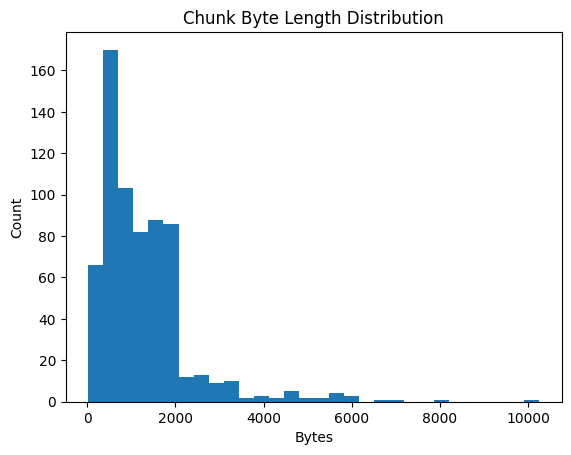

ーーーーーーlength_bytesーーーーーー
count      666.000000
mean      1290.666667
std       1106.507735
min         27.000000
25%        597.250000
50%       1019.500000
75%       1692.250000
max      10249.000000
Name: length_bytes, dtype: float64
ーーーーーーlength_charsーーーーーー
count     666.000000
mean      475.660661
std       436.391397
min         9.000000
25%       216.250000
50%       377.000000
75%       614.750000
max      5079.000000
Name: length_chars, dtype: float64
                                       filename  chunk_idx  \
15              4年生きたハムスターと2年生きたハムスターの飼育の違い.txt          3   
51   【2027年最新】オススメのハムスター用品ランキング【Tier List】.txt          3   
71                【それ危険！】やりがちな誤ったハムスター飼育方法.txt          7   
99                    【ハムスターに優しい】お迎えするステップ.txt          3   
108               【予防できる】ハムスターが罹りやすい病気　５選.txt          3   
187                   【科学的】 ハムスター疑似冬眠を防ぐ方法.txt          2   
243             【覚悟が必要】ハムスターを飼うと必ず起こる辛いこと.txt          2   
255  【飼主に読んで欲しい本】猫を救うのは誰かペットビジネスの「奴隷

In [15]:
# サイズ分布の可視化（バイト数/文字数）
plt.hist(df["length_bytes"], bins=30)
plt.title("Chunk Byte Length Distribution")
plt.xlabel("Bytes")
plt.ylabel("Count")
plt.show()

# 平均・最大・最小など統計
print("ーーーーーーlength_bytesーーーーーー")
print(df["length_bytes"].describe())
print("ーーーーーーlength_charsーーーーーー")
print(df["length_chars"].describe())

# 上限超え（例：4000バイト）だけ抽出
over_limit = df[df["length_bytes"] > 4000]
print(over_limit)

# 短すぎるチャンク（例：100バイト未満）も確認
under_limit = df[df["length_bytes"] < 100]
print(under_limit)

In [16]:
# 大きすぎ・小さすぎ・空文字・URLのみ のチャンクを除外
min_bytes = 80
max_bytes = 3500

def is_meaningful(text):
    if pd.isnull(text): return False
    # 空白・記号だけ・URLだけのチャンクを除外
    txt = text.strip()
    if txt == "": return False
    if txt.startswith("http") or txt.startswith("---"): return False
    if len(txt.replace("　", "").replace("\n", "")) < 5: return False
    return True

# csvから読み込み＆フィルタ
df = pd.read_csv("chunk_stats.csv")
filtered = df[
    (df["length_bytes"] >= min_bytes) &
    (df["length_bytes"] <= max_bytes) &
    (df["text"].apply(is_meaningful))
]
filtered_final = filtered.reset_index(drop=True)
print(filtered_final["length_bytes"].max())  # 必ず4_194_304未満！


3406


In [17]:
print(filtered_final["length_bytes"].max())
print(filtered_final[filtered_final["length_bytes"] > 4194304])

3406
Empty DataFrame
Columns: [filename, chunk_idx, text, length_chars, length_bytes]
Index: []


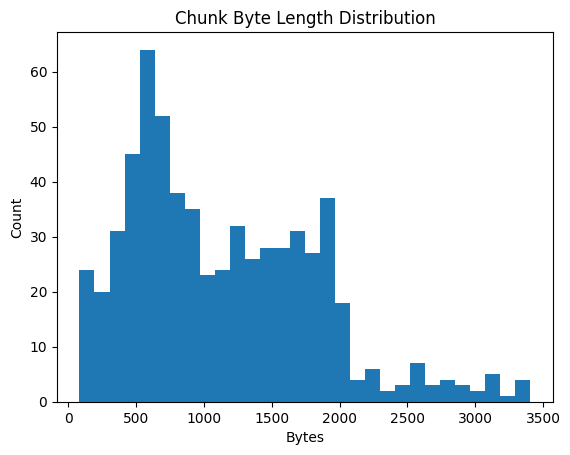

ーーーーーーlength_bytesーーーーーー
count     627.000000
mean     1137.771930
std       684.542638
min        82.000000
25%       597.500000
50%       994.000000
75%      1634.000000
max      3406.000000
Name: length_bytes, dtype: float64
ーーーーーーlength_charsーーーーーー
count     627.000000
mean      416.915470
std       259.781133
min        28.000000
25%       216.500000
50%       363.000000
75%       594.000000
max      1996.000000
Name: length_chars, dtype: float64
Empty DataFrame
Columns: [filename, chunk_idx, text, length_chars, length_bytes]
Index: []
                      filename  chunk_idx                           text  \
174  【科学的】 ハムスター疑似冬眠を防ぐ方法.txt          3  その原因は特大ケージを使わないから\nではないでしょうか？   
515   喜んでいる時のハムスターの鳴き声_３選.txt          7  聞こえたらラッキーくらいに\n考えておくと良いと思います！   

     length_chars  length_bytes  
174            28            82  
515            28            82  


In [18]:
# Debug: チャンクサイズの分布確認
# 無駄チャンクがフィルタリングされたことを確認

# サイズ分布の可視化（バイト数/文字数）
plt.hist(filtered_final["length_bytes"], bins=30)
plt.title("Chunk Byte Length Distribution")
plt.xlabel("Bytes")
plt.ylabel("Count")
plt.show()

# 平均・最大・最小など統計
print("ーーーーーーlength_bytesーーーーーー")
print(filtered_final["length_bytes"].describe())
print("ーーーーーーlength_charsーーーーーー")
print(filtered_final["length_chars"].describe())

# 上限超え（例：4000バイト）だけ抽出
over_limit = filtered_final[filtered_final["length_bytes"] > 4000]
print(over_limit)

# 短すぎるチャンク（例：100バイト未満）も確認
under_limit = filtered_final[filtered_final["length_bytes"] < 100]
print(under_limit)

In [19]:
# “全部まとめてupsert”はデータサイズが大きすぎて無理なので
# 100件ずつ分割アップロード

# チャンク＆埋め込み作成（filtered_final["text"].tolist()に合わせる）
filtered_chunks = filtered_final["text"].tolist()
filtered_embeddings = [get_embedding(chunk) for chunk in filtered_chunks]

# アップロード
vectors = []
for i, (embedding, text) in enumerate(zip(filtered_embeddings, filtered_chunks)):
    vector_id = f"chunk{i+1}"
    metadata = {"text": text}
    vectors.append((vector_id, embedding, metadata))

# 100件ずつ小分けアップロード！
BATCH_SIZE = 100
for i in range(0, len(vectors), BATCH_SIZE):
    batch = vectors[i:i+BATCH_SIZE]
    index.upsert(vectors=batch)
    print(f"✅ Uploaded batch {i // BATCH_SIZE + 1}")

✅ Uploaded batch 1
✅ Uploaded batch 2
✅ Uploaded batch 3
✅ Uploaded batch 4
✅ Uploaded batch 5
✅ Uploaded batch 6
✅ Uploaded batch 7


### 上記コードをリファクタリング

In [34]:
# --- 必要なパッケージのインポート ---
from openai import OpenAI
from pinecone import Pinecone
import nltk
import os
import re
import pandas as pd

nltk.download('punkt')

# --- APIクライアント初期化 ---
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("hamster-embeddings")

directory = "./senarios"

# --- チャンク分割関数（文単位・バイト長制限も追加） ---
def split_to_line_chunks(text, max_lines=5, max_chars=2000):
    # 1行を1文とみなす
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    chunks = []
    chunk = ""
    count = 0
    for line in lines:
        # バイト数制限
        if len(chunk.encode("utf-8")) + len(line.encode("utf-8")) > max_chars:
            if chunk:
                chunks.append(chunk.strip())
            chunk = ""
            count = 0
        chunk += line + "\n"
        count += 1
        if count >= max_lines:
            chunks.append(chunk.strip())
            chunk = ""
            count = 0
    if chunk:
        chunks.append(chunk.strip())
    return chunks

# --- OpenAI埋め込み ---
def get_embedding(text):
    res = client.embeddings.create(input=[text], model="text-embedding-3-small")
    return res.data[0].embedding

# --- チャンク分割と情報記録 ---
MAX_SENTENCES_PER_CHUNK = 5
chunk_info = []

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
            text = f.read()
        new_chunks = split_to_line_chunks(text, max_lines=MAX_SENTENCES_PER_CHUNK)
        for i, chunk in enumerate(new_chunks):
            chunk_info.append({
                'filename': filename,
                'chunk_idx': i + 1,
                'text': chunk,
                'length_chars': len(chunk),
                'length_bytes': len(chunk.encode('utf-8')),
            })

# --- チャンク情報をDataFrame化し可視化・保存 ---
df = pd.DataFrame(chunk_info)
df.to_csv("chunk_stats.csv", index=False)
print(df["length_bytes"].describe())

# --- フィルタリング ---
min_bytes = 80
max_bytes = 3500

def is_meaningful(text):
    if pd.isnull(text): return False
    txt = text.strip()
    if txt == "": return False
    if txt.startswith("http") or txt.startswith("---"): return False
    if len(txt.replace("　", "").replace("\n", "")) < 5: return False
    return True

filtered = df[
    (df["length_bytes"] >= min_bytes) &
    (df["length_bytes"] <= max_bytes) &
    (df["text"].apply(is_meaningful))
].reset_index(drop=True)

filtered_chunks = filtered["text"].tolist()
print(f"Upload対象チャンク数: {len(filtered_chunks)}")

# --- 埋め込み生成 ---
filtered_embeddings = [get_embedding(chunk) for chunk in filtered_chunks]

# --- Pineconeにバッチアップロード ---
def upload_in_batches(vectors, batch_size=100):
    for i in range(0, len(vectors), batch_size):
        batch = vectors[i:i + batch_size]
        index.upsert(vectors=batch)
        print(f"✅ Uploaded batch {i//batch_size + 1}")

vectors = [
    (f"chunk{i+1}", embedding, {"text": text})
    for i, (embedding, text) in enumerate(zip(filtered_embeddings, filtered_chunks))
]

upload_in_batches(vectors, batch_size=100)
print("✅ 全チャンクのアップロードが完了しました！")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


count    4590.000000
mean      185.236383
std        72.051295
min         9.000000
25%       163.000000
50%       184.000000
75%       202.000000
max      2000.000000
Name: length_bytes, dtype: float64
Upload対象チャンク数: 4530
✅ Uploaded batch 1
✅ Uploaded batch 2
✅ Uploaded batch 3
✅ Uploaded batch 4
✅ Uploaded batch 5
✅ Uploaded batch 6
✅ Uploaded batch 7
✅ Uploaded batch 8
✅ Uploaded batch 9
✅ Uploaded batch 10
✅ Uploaded batch 11
✅ Uploaded batch 12
✅ Uploaded batch 13
✅ Uploaded batch 14
✅ Uploaded batch 15
✅ Uploaded batch 16
✅ Uploaded batch 17
✅ Uploaded batch 18
✅ Uploaded batch 19
✅ Uploaded batch 20
✅ Uploaded batch 21
✅ Uploaded batch 22
✅ Uploaded batch 23
✅ Uploaded batch 24
✅ Uploaded batch 25
✅ Uploaded batch 26
✅ Uploaded batch 27
✅ Uploaded batch 28
✅ Uploaded batch 29
✅ Uploaded batch 30
✅ Uploaded batch 31
✅ Uploaded batch 32
✅ Uploaded batch 33
✅ Uploaded batch 34
✅ Uploaded batch 35
✅ Uploaded batch 36
✅ Uploaded batch 37
✅ Uploaded batch 38
✅ Uploaded batch 39
✅ Uplo

# 🧠 以上で **RAG基盤の準備完了！**
 
## ✅ 次のステップ: **RAGの完成形に向けた構築**
### 1.検索機能実装

- クエリテキストを入力し、その埋め込みベクトルを生成。
- Pineconeで類似ベクトルを検索し、最も近いテキストを取得。

### 2.OpenAIへのプロンプト生成

- 検索結果から得たチャンクを組み合わせて「コンテキスト付きプロンプト」を構築。
- ChatGPTにそのプロンプトを送信し、回答を得る。

### 3.ユーザーインターフェース（Flutter）
- ユーザーがクエリを入力し、検索〜応答生成を体験できるUI(モバイルアプリ)を構築。

### 4.チャットの履歴保存や拡張（任意）
- 会話履歴を保存、マルチターンの対話なども視野に。




# 🔨 DeBug Code
### 本当にチャンクがDBに入っているかチェック

まず、PineconeのダッシュボードやAPIを使って、特定のチャンク（例えば「なぜ脱走するのですか？」や「そこに穴があるからだ」など）のtextが登録されているか確認。

In [23]:
# すべてのチャンクをdumpして特定のキーワードを含むものを探す
for idx, chunk in enumerate(filtered_chunks):
    if "脱走" in chunk or "そこに穴がある" in chunk:
        print(f"[{idx}] {chunk[:100]} ...")

[9] そして日本のペットショップでは
そんな大きなケージは売ってません
だから衣装ケースを購入するか
魚用の水槽を購入するのが理想的です

ヨーロッパで言われている皮肉に
「ハムにはウサギ用ケージの広さが必 ...
[16] この動画が好評だった場合は
他のグッズも試しに色々買って
皆さんにレビューしたいと思うので
ぜひ感想をコメント欄に書いて下さい

それでは早速いきましょう！

NiteAngelオススメ商品　
その１ ...
[31] ハムは１年経てば
かなり年齢を重ねます
１年で飼育方法を変えるのは
当然といえば当然ですね

また新しく試した
飼育グッズもあるので
かなり大きな変化がありました
この動画が皆さんの
ハム飼育の参考に ...
[32] 空気が籠らないから
寒くならないのか？
そんな声が聞こえてきます

勿論私の飼育環境では
脱走しない事を確信していて
虫も湧かない事が分かっていて
部屋全体がいつでも暖かいから
やっています

なので ...
[33] そんな事を私は想像しました
ハムが脱走したがる理由
その一つには空気の淀みが
あるのではないかなと

エビデンスがある話もすると
二酸化炭素濃度が高くなると
不快感・頭痛・吐き気
等を催すし
睡眠も浅 ...
[42] ちなみにAmazonではBlackFridayで
なんど２０%OFFで買えます

水入れ 富士山シリーズ（カルデラ湖っぽい）：
https://amzn.to/3yyUTkS

ハムに水を与える為のグ ...
[66] しかし、特例として
ハムの活動の様子が
いつも違う時は
やむを得ず巣箱を確認する
必要がある場合もあります。

具体的には、数日間
夜にハムを見かけない
回し車を回している音がしない
エサが減っていな ...
[128] 冬用の寝床作りは、
本能と習性による行動ですので、
どのハムスターも行います。

では、私たち飼い主は
どのようにサポートすれば
良いでしょうか？

まず、
①床材の量をいつもより
多めに入れよう

 ...
[131] 皆さんこんにちは
Goです
今回は

【徹底レビュー】
1年以上使って気がついた
BUCASTATEの良い点悪い点を
徹底レビューします

BUCASTATEは全飼主に
オススメしたい特大ケージですが ...
[132] という

### チャンク（filtered_final[“text”]）に該当フレーズが「部分一致」で含まれているか確認：

In [24]:
import pandas as pd

df = pd.read_csv("filtered_chunks.csv")  # あなたの filtered_final に相当

# 検索したいキーワード
targets = [
    "なぜ脱走するのですか",
    "そこに穴があるからだ",
    "脱走します",
    "脱走"
]

for t in targets:
    result = df[df["text"].str.contains(t, na=False)]
    print(f"--- '{t}' を含むチャンク ---")
    if result.empty:
        print("該当なし")
    else:
        for i, row in result.iterrows():
            print(f"chunk_idx: {row['chunk_idx']}, length: {row['length_bytes']} bytes")
            print(row["text"])
            print("----")

--- 'なぜ脱走するのですか' を含むチャンク ---
chunk_idx: 1, length: 392 bytes
後悔してからだと遅いです

皆さんこんにちは
Goです
今回は
脱走したハムを捕まえる方法
を紹介します

皆さんに重要な話をします
ハムスターは
脱走します

あなたに懐いていても
脱走します
快適な飼育環境があっても
脱走します

脱走する事に理由はないんです
なぜ脱走するのですか？
----
--- 'そこに穴があるからだ' を含むチャンク ---
該当なし
--- '脱走します' を含むチャンク ---
chunk_idx: 1, length: 392 bytes
後悔してからだと遅いです

皆さんこんにちは
Goです
今回は
脱走したハムを捕まえる方法
を紹介します

皆さんに重要な話をします
ハムスターは
脱走します

あなたに懐いていても
脱走します
快適な飼育環境があっても
脱走します

脱走する事に理由はないんです
なぜ脱走するのですか？
----
--- '脱走' を含むチャンク ---
chunk_idx: 5, length: 1386 bytes
そして日本のペットショップでは
そんな大きなケージは売ってません
だから衣装ケースを購入するか
魚用の水槽を購入するのが理想的です

ヨーロッパで言われている皮肉に
「ハムにはウサギ用ケージの広さが必要で
　ウサギにはワンルームの広さが必要だ」
というものがあります


話をまとめると
馬もウサギもハムスターも
人間に飼われている動物は
人の生活サイズに無理矢理合わせられてる
その事を忘れてはなりません
部屋の広さに余裕がある人は
横幅１ｍくらいの衣装ケースを使う事を
おススメします

因みに余談ですが私の飼っていた
ジャンハムのタピオカちゃんは
4年以上も生きてくれました
その要因はハッキリ分かりませんが

実はタピちゃんが3歳になるまでは
夜は部屋で放し飼いにしてたんですよね
脱走のリスクがあるので
マネするのはお勧めしませんが
広い部屋を伸び伸びと走り回れた事も
もしかしたら長寿に繋がってるのかもなぁ
なんて事を思いました


ハムの平均寿命は２～３年ですが
飼育環境をもっと最適化することで
寿命はどんどん延びるかも知れませんね
ぜひ参考にしてくださいね！
----
c

### Pinecone に本当に新しいチャンクと埋め込みが上がっているか確認
1.	Pinecone コンソール で対象のインデックス（hamster-embeddings）を開き、

•	RECORD COUNT が増えているか（たとえば .ipynb を再実行する前後で 11 → もっと大きな数に変わっているか）

•	Namespaces が変わっていないか

2.	コード上で stats を取ってみる

In [ ]:
import os
from pinecone import Pinecone

# ① Pinecone クライアントを初期化（environment が必要な場合は適宜追加）
pc = Pinecone(
    api_key=os.environ["PINECONE_API_KEY"],
    environment=os.environ.get("PINECONE_ENVIRONMENT", "us-east-1-aws"),
)

# ② Index オブジェクトを取得
index = pc.Index("hamster-embeddings")

# ③ 統計情報を取得
stats = index.describe_index_stats()
print(stats)

この出力によって、
	•	total_vector_count が、期待しているチャンク数（たとえばTXTファイルを分割した総チャンク数）と一致しているか
	•	ネームスペース（通常は空文字列 ''）に正しくベクトルが入っているか

を確認できます。

In [21]:
import os
from pinecone import Pinecone

# Pinecone クライアントとインデックス取得
pc = Pinecone(
    api_key=os.environ["PINECONE_API_KEY"],
    environment=os.environ.get("PINECONE_ENVIRONMENT", "us-east-1-aws"),
)
index = pc.Index("hamster-embeddings")

# 統計情報を取得
stats = index.describe_index_stats()

# 全体のベクトル数
print("▶ total_vector_count:", stats["total_vector_count"])

# ネームスペースごとの詳細（デフォルトネームスペースは '' になります）
for ns, data in stats["namespaces"].items():
    print(f"▶ namespace '{ns}' → vector_count: {data['vector_count']}")

▶ total_vector_count: 627
▶ namespace '' → vector_count: 627


In [ ]:
print(pc.list_indexes())

最速で「現状」を可視化・特定するための手順

1. 現在の Pinecone インデックスの状態をAPI経由で「全文検索」してみる

•	ここで vector_count が 627（アップロード時と同じ）か確認。
	•	もし全く違う件数だったり、古い件数だったりしたら、「参照先 Pinecone が異なっている」ことが確定

In [28]:
# Pinecone インデックスのベクトル件数・チャンクの一部を確認する
from pinecone import Pinecone

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("hamster-embeddings")

stats = index.describe_index_stats()
print("▶ total_vector_count:", stats["total_vector_count"])

for ns, data in stats["namespaces"].items():
    print(f"▶ namespace '{ns}' → vector_count: {data['vector_count']}")

▶ total_vector_count: 4530
▶ namespace '' → vector_count: 4530


In [31]:
stats = index.describe_index_stats()
print("▶ total_vector_count:", stats["total_vector_count"])

▶ total_vector_count: 4530


対策方針

A. 「今のインデックスを完全初期化（全削除）してから再アップロード」

In [29]:
from pinecone import Pinecone

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("hamster-embeddings")

# 全削除（※全ベクトル消えるのでご注意！）
index.delete(delete_all=True)
print("全ベクトルを削除しました")

全ベクトルを削除しました


2. データ量の確認
	•	大量アップロードが問題なら、ファイルの合計サイズを先に調べるのも有効です
	•	合計バイト

In [32]:
import os

directory = "./senarios"
total_bytes = 0
file_count = 0

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        path = os.path.join(directory, filename)
        file_count += 1
        total_bytes += os.path.getsize(path)
        print(f"{filename}: {os.path.getsize(path)} bytes")

print(f"\n合計ファイル数: {file_count}")
print(f"合計バイト数: {total_bytes} bytes = {total_bytes/1024/1024:.2f} MB")

1ヶ月間ハムスターの走る距離を測って分かったこと.txt: 7463 bytes
2021年　おススメのハムスターケージ TOP3.txt: 10265 bytes
4年生きたハムスターと2年生きたハムスターの飼育の違い.txt: 10246 bytes
NiteAngel.txt: 8967 bytes
◯◯メインでハムスターのエサを選ぶとマジで損します【このペレットはおすすめしません】.txt: 5818 bytes
★このハムスターグッズ優秀です３選.txt: 534 bytes
★ハムスタールーティン.txt: 534 bytes
★優しい人に育てられたハムスターが見せる行動.txt: 534 bytes
★嫌っているように見えて実は好きを伝えているハムスターの行動.txt: 489 bytes
【15個】ハムスター飼育で重宝しているグッズ.txt: 7790 bytes
【2023年】ハムスター飼育をこう変えました.txt: 11738 bytes
【2024年ベストバイ】ハムスター飼育で毎日使っているアイテム.txt: 8646 bytes
【2027年最新】オススメのハムスター用品ランキング【Tier List】.txt: 12178 bytes
【QOLが上がる】ハムスターとのスキンシップ時間.txt: 5383 bytes
【View用】コレを知らずにハムスターを飼育しないで.txt: 4272 bytes
【これが見られたら要注意】老いたハムスターが見せる行動　３選.txt: 6306 bytes
【それ危険！】やりがちな誤ったハムスター飼育方法.txt: 11028 bytes
【ひろゆき】そのハムスターグッズ使ってるってやばくないですか？.txt: 6637 bytes
【やりがち】ハムスター飼育のNG行動.txt: 3234 bytes
【アナタにも？】ハムスターを飼うと発症しうるアレルギー.txt: 7271 bytes
【ハムの天敵！】湿度対策　TOP3.txt: 6989 bytes
【ハムスターに優しい】お迎えするステップ.txt: 9218 bytes
【ハムスター飼育】効果的な暖房の使い方.txt: 6211 bytes
【予防できる】ハムスターが罹りやすい病気